In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np

In [ ]:
source = '/content/drive/MyDrive/Datasets/flood image segmentation.zip'
destination = '/content/data'

with zipfile.ZipFile(source, 'r') as zip_ref:
  zip_ref.extractall(destination)

In [ ]:
class FloodSegmentationDataset(Dataset):
    def __init__(self, csv_file, input_dir, target_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the input and target image filenames from metadata
        input_img_name = os.path.join(self.input_dir, self.data.iloc[idx, 0])
        target_mask_name = os.path.join(self.target_dir, self.data.iloc[idx, 1])

        # Load the images
        input_image = Image.open(input_img_name).convert("RGB")
        target_mask = Image.open(target_mask_name).convert("L")  # Assuming mask is grayscale

        # Apply transformations
        if self.transform:
            input_image = self.transform(input_image)
        if self.target_transform:
            target_mask = self.target_transform(target_mask)

        return input_image, target_mask

In [ ]:
# Define transformations for input and target images
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use standard normalization for pre-trained models
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Convert to tensor, but no normalization for mask
])

In [ ]:
# Create dataset and dataloader
dataset = FloodSegmentationDataset(
    csv_file="/content/data/metadata.csv",
    input_dir="/content/data/Image",
    target_dir="/content/data/Mask",
    transform=input_transform,
    target_transform=target_transform
)

In [ ]:
# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [ ]:
# Example of iterating through the dataloader
for input_img, target_mask in dataloader:
    print(input_img.shape, target_mask.shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
torch.Size([10, 3, 256, 256]) torch.Size

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=64):
        super(UNet, self).__init__()
        features = init_features

        # Encoder (Contracting Path)
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)

        # Bottleneck
        self.bottleneck = UNet._block(features * 8, features * 16)

        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features)

        # Final Output Layer (1x1 Convolution)
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    @staticmethod
    def _block(in_channels, features, kernel_size=3, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        # Decoding path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenate with encoder output
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final layer
        return torch.sigmoid(self.conv(dec1))  # Use sigmoid for binary segmentation

# Initialize the model
unet = UNet(in_channels=3, out_channels=1)
print(unet)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
# Run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = UNet(in_channels=3, out_channels=1)  # Adjust in_channels/out_channels based on your task
model = model.to(device)  # Move the model to GPU if available

# Define the loss function
criterion = nn.BCELoss()  # Use nn.BCELoss for binary segmentation, or nn.CrossEntropyLoss for multi-class segmentation

# Define the optimizer (Adam is commonly used)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust the learning rate as needed

In [ ]:
# Assuming 'dataloader' is defined, and 'device' is 'cuda' or 'cpu'
num_epochs = 25  # Define the number of epochs
train_loader = dataloader  # Replace with your DataLoader object

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_idx, (input_img, target_mask) in enumerate(train_loader):
        # Move data to the same device as the model (GPU or CPU)
        input_img = input_img.to(device)
        target_mask = target_mask.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted output by passing input to the model
        outputs = model(input_img)

        # Compute the loss between output and target mask
        loss = criterion(outputs, target_mask)

        # Backward pass: Compute gradient of the loss w.r.t. model parameters
        loss.backward()

        # Perform optimization step (update weights)
        optimizer.step()

        # Print running loss (optional)
        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/25], Step [10/29], Loss: 0.4183
Epoch [1/25], Step [20/29], Loss: 0.3886
Epoch [1/25] completed, Average Loss: 0.4462
Epoch [2/25], Step [10/29], Loss: 0.3481
Epoch [2/25], Step [20/29], Loss: 0.3557
Epoch [2/25] completed, Average Loss: 0.3700
Epoch [3/25], Step [10/29], Loss: 0.3310
Epoch [3/25], Step [20/29], Loss: 0.3764
Epoch [3/25] completed, Average Loss: 0.3572
Epoch [4/25], Step [10/29], Loss: 0.3212
Epoch [4/25], Step [20/29], Loss: 0.2825
Epoch [4/25] completed, Average Loss: 0.3368
Epoch [5/25], Step [10/29], Loss: 0.3000
Epoch [5/25], Step [20/29], Loss: 0.2911
Epoch [5/25] completed, Average Loss: 0.3310
Epoch [6/25], Step [10/29], Loss: 0.2721
Epoch [6/25], Step [20/29], Loss: 0.3076
Epoch [6/25] completed, Average Loss: 0.3164
Epoch [7/25], Step [10/29], Loss: 0.2472
Epoch [7/25], Step [20/29], Loss: 0.3115
Epoch [7/25] completed, Average Loss: 0.3107
Epoch [8/25], Step [10/29], Loss: 0.3100
Epoch [8/25], Step [20/29], Loss: 0.3950
Epoch [8/25] completed, Avera

In [ ]:
# Folder containing input images
image_folder = '/content/test images'

# Preprocessing (similar to what you used during training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size of your model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Adjust normalization as per training
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image

# List of image paths
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]

In [ ]:
# Assuming your trained model is already in memory as 'model'
predicted_masks = []
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for img_path in image_paths:
        input_image = preprocess_image(img_path)  # Preprocess each image
        input_image = input_image.to(device)  # Move to GPU if necessary
        output = model(input_image)  # Forward pass through the model
        predicted_mask = output.squeeze(0).cpu()  # Remove batch dimension and move to CPU
        predicted_masks.append(predicted_mask)


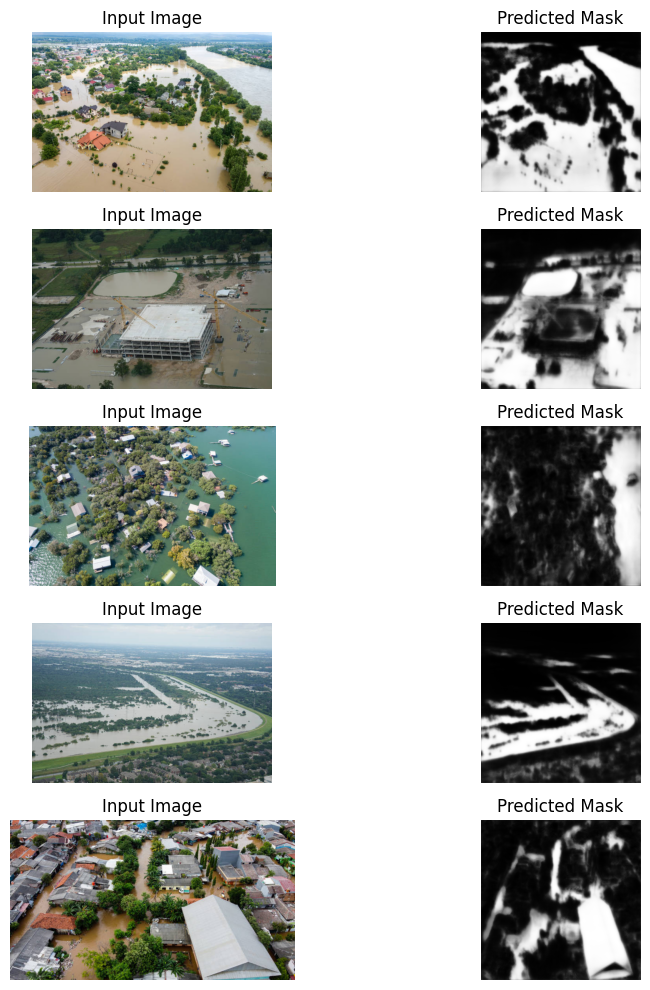

In [ ]:
# Function to display input image and mask
def visualize_predictions(image_paths, predicted_masks):
    fig, axs = plt.subplots(len(image_paths), 2, figsize=(10, 10))  # Create grid for images and masks

    for i, (img_path, mask) in enumerate(zip(image_paths, predicted_masks)):
        # Load the original image for visualization
        original_image = Image.open(img_path)

        # Display original input image
        axs[i, 0].imshow(original_image)
        axs[i, 0].set_title("Input Image")
        axs[i, 0].axis('off')

        # Display predicted mask
        axs[i, 1].imshow(mask.squeeze().numpy(), cmap='gray')  # Convert mask to numpy and visualize
        axs[i, 1].set_title("Predicted Mask")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the input images with their predicted masks
visualize_predictions(image_paths, predicted_masks)